In [1]:
# Importing the Libraries
import pandas as pd
import numpy as np
from numpy import arange
from matplotlib import pyplot as plt
from sklearn import metrics
from scipy.optimize import curve_fit
import scipy.stats as st
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the Dataset and display few records
world_data = pd.read_csv("World_data.csv")
world_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,134.772341
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,88.061110
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.591951
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,81.324186
4,Arab World,ARB,Aquaculture production (metric tons),ER.FSH.AQUA.MT,1960,4600.000000


In [3]:
#Picking the required Indicators ( Total Emissions, Emissions from Solid Fuels, Emissions from Liquid Fuels and Emissions from Gases)
total_emission_df = world_data[world_data["IndicatorName"] == "CO2 emissions (kt)"]
solid_emission_df = world_data[world_data["IndicatorName"] == "CO2 emissions from solid fuel consumption (kt)"]
liquid_emission_df = world_data[world_data["IndicatorName"] == "CO2 emissions from liquid fuel consumption (kt)"]
gaseous_emission_df = world_data[world_data["IndicatorName"] == "CO2 emissions from gaseous fuel consumption (kt)"]

total_emission_df.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
11,Arab World,ARB,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,5.600530e+04
146,Caribbean small states,CSS,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,5.878201e+03
280,Central Europe and the Baltics,CEB,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,4.665334e+05
411,Early-demographic dividend,EAR,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,5.914790e+05
601,East Asia & Pacific,EAS,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,1.215380e+06


In [4]:
#Merging all into a Single Dataframe
total_data = total_emission_df.copy()
total_data = total_data[["CountryCode", "Year", "Value"]].merge(solid_emission_df[["CountryCode", "Year", "Value"]], on=["CountryCode", "Year"], suffixes=("_tot", "_sol"))
total_data = total_data[["CountryCode", "Year", "Value_tot", "Value_sol"]].merge(liquid_emission_df[["CountryCode", "Year", "Value"]], on=["CountryCode", "Year"], suffixes=("_tot", "_liq"))
total_data = total_data[["CountryCode", "Year", "Value_tot", "Value_sol", "Value"]].merge(gaseous_emission_df[["CountryCode", "Year", "Value"]], on=["CountryCode", "Year"], suffixes=("_liq", "_gas"))
total_data.head()

,CountryCode,Year,Value_tot,Value_sol,Value_liq,Value_gas
0,HIC,1960,5.777370e+06,2.782020e+06,2.206355e+06,765264.661704
1,IBD,1960,3.578667e+06,2.528717e+06,7.956873e+05,179742.038578
2,IBT,1960,3.689618e+06,2.604416e+06,8.393268e+05,193732.553808
3,LTE,1960,2.887399e+06,2.199138e+06,5.672444e+05,131865.428748
4,LCN,1960,3.024539e+05,2.578318e+04,2.046596e+05,22079.989987


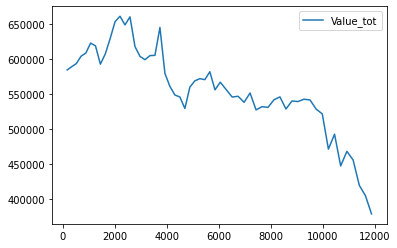

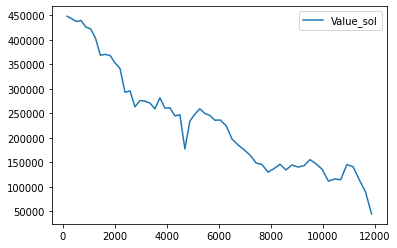

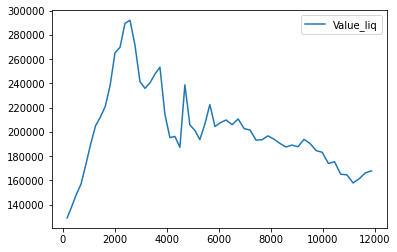

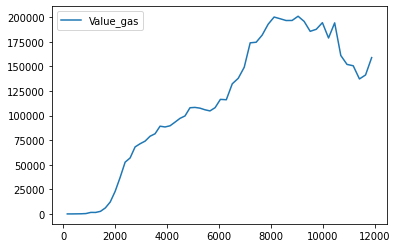

In [5]:
# Filtering the Data for GBR country ( Great Britain )
gbr_data = total_data[total_data["CountryCode"]=="GBR"]

def plot_lines(df, col_name):
    df[[col_name]].plot()
    
plot_lines(gbr_data, "Value_tot")
plot_lines(gbr_data, "Value_sol")
plot_lines(gbr_data, "Value_liq")
plot_lines(gbr_data, "Value_gas")

In [6]:
#Creation of a function to Normalize the data for Value Column
def normalize_data(df):
    normalized_df=(df["Value_tot"]-df["Value_tot"].mean())/df["Value_tot"].std()
    return normalized_df

<AxesSubplot:xlabel='Year', ylabel='Value_tot'>

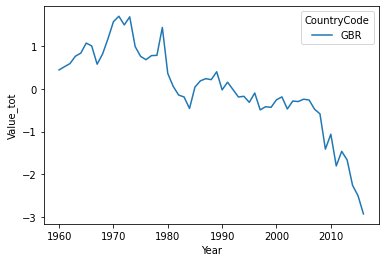

In [7]:
#Lineplot to display Normalized Emission values for all the years for GBR
gbr_data = gbr_data.replace("..", 0)
gbr_data["Value_tot"] = normalize_data(gbr_data)
sns.lineplot(x='Year',y='Value_tot', hue='CountryCode', err_style='bars', data=gbr_data)

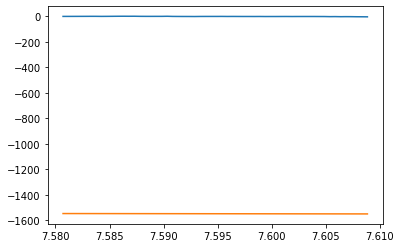

In [8]:
#Applying Polynomial Curve_fit
x_data = gbr_data["Year"]
y_data = gbr_data["Value_tot"]
# Taking log of x values
xlog_data = np.log(x_data)             
# Fitting of Data by Given log values as input
curve = np.polyfit(xlog_data, y_data, 1)
a = curve[0]  
b = curve[1]
y = a * xlog_data - b  
# Blue color
plt.plot(xlog_data, y_data)
  
# Best fit in orange
plt.plot(xlog_data, y) 

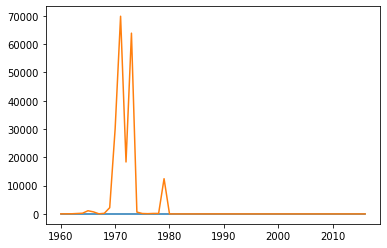

In [9]:
#Applying Exponential curve fitting
x_data = gbr_data["Year"]
y_data = gbr_data["Value_tot"]
xlog_data = np.log(x_data)

curve_fit = np.polyfit(x_data, xlog_data, 1)
#print(curve_fit)
a = curve_fit[0]  
b = curve_fit[1]
y = np.exp(a) * np.exp(b*y_data)
#print(y)
# Blue 
plt.plot(x_data, xlog_data)
  
# best fit in orange
plt.plot(x_data, y)

In [10]:
#Calculation of lower and upper Confidence Intervals on Emission Value

lower, upper = st.t.interval(0.95, len(gbr_data["Value_tot"])-1, loc=np.mean(gbr_data["Value_tot"]), scale=st.sem(gbr_data["Value_tot"]))
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    import numpy as np
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

In [11]:
#Printing of lower and Upper Confidence Intervals ranges
print(lower)
print(upper)

-0.2653357149314559
0.26533571493145813


In [12]:
#Plotting the COnfidence Range with lower and Upper Values and Applyig the fitting
#Creation of function to plot the Confidence Range 
def plot_graph(colored=False):
    for lower,upper,y in zip(gbr_data["Value_tot"],gbr_data["Value_tot"],range(len(gbr_data["Value_tot"]))):
        curve_fit = np.polyfit(x_data, xlog_data, 1)
        #print(curve_fit)
        a = curve_fit[0]  
        b = curve_fit[1]
        y = np.exp(a) * np.exp(b*y_data)
        plt.plot((lower,upper),(y,y),'ro-',color='orange')

    #adding overall title
    plt.title('Confidence Range Plot', fontsize=16)

    #adding axis titles
    plt.xlabel('Lower and Upper Values')
    plt.ylabel('Co2 Emissions')
    plt.show()

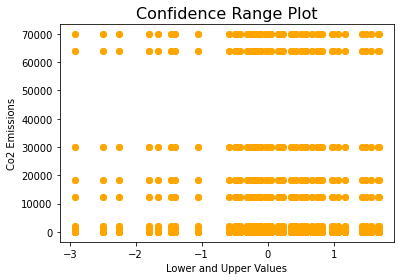

In [13]:
#Plotting the Confidence Range
plot_graph()

In [14]:
# Converting the data into categorical values
total_data["CountryCode"] = total_data["CountryCode"].astype("category").cat.codes
total_data.head()

,CountryCode,Year,Value_tot,Value_sol,Value_liq,Value_gas
0,88,1960,5.777370e+06,2.782020e+06,2.206355e+06,765264.661704
1,94,1960,3.578667e+06,2.528717e+06,7.956873e+05,179742.038578
2,95,1960,3.689618e+06,2.604416e+06,8.393268e+05,193732.553808
3,129,1960,2.887399e+06,2.199138e+06,5.672444e+05,131865.428748
4,123,1960,3.024539e+05,2.578318e+04,2.046596e+05,22079.989987


In [15]:
# Applying KMeans Model and fitting the data and predicting the value with k value as 9 clusters
from sklearn.cluster import KMeans

model = KMeans(n_clusters=9)
model.fit(total_data)
y_pred = model.predict(total_data)
clusters = list(set(y_pred))
clusters

[0, 1, 2, 3, 4, 5, 6, 7, 8]

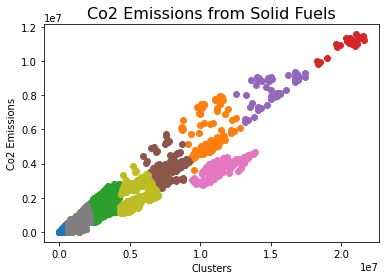

In [16]:
# Clusters of Solid Fuel emissions shown in a scatter plot
from numpy import where

def draw_clusters(temp_df, col_name):
    plt.scatter(temp_df["Value_tot"], temp_df[col_name])

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    temp_df = total_data.iloc[row_ix]
    draw_clusters(temp_df, "Value_sol")

#adding overall title
plt.title('Co2 Emissions from Solid Fuels', fontsize=16)

#adding axis titles
plt.xlabel('Clusters')
plt.ylabel('Co2 Emissions')
plt.show()

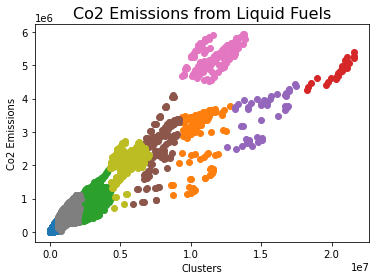

In [17]:
# Clusters of Liquid Fuel emissions shown in a scatter plot
for cluster in clusters:
    row_ix = where(y_pred == cluster)
    temp_df = total_data.iloc[row_ix]
    draw_clusters(temp_df, "Value_liq")
#adding overall title
plt.title('Co2 Emissions from Liquid Fuels', fontsize=16)

#adding axis titles
plt.xlabel('Clusters')
plt.ylabel('Co2 Emissions')
plt.show()

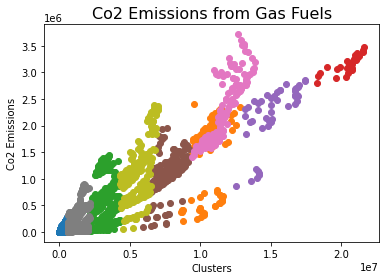

In [18]:
# Clusters of Gas emissions shown in a scatter plot
for cluster in clusters:
    row_ix = where(y_pred == cluster)
    temp_df = total_data.iloc[row_ix]
    draw_clusters(temp_df, "Value_gas")
#adding overall title
plt.title('Co2 Emissions from Gas Fuels', fontsize=16)

#adding axis titles
plt.xlabel('Clusters')
plt.ylabel('Co2 Emissions')
plt.show()

In [19]:
#Reducing the Features
total_data = total_data.drop(['Year','Value_tot','Value_sol','Value_liq'], axis = 1)

In [20]:
#Applying the Model and Fitting the Data with reduced features
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9)
kmeans.fit(total_data)
y_kmeans = kmeans.predict(total_data)

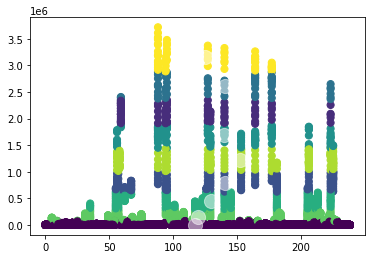

In [21]:
#Calculating the Centroids of Clusters
plt.scatter(total_data.iloc[:, 0], total_data.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

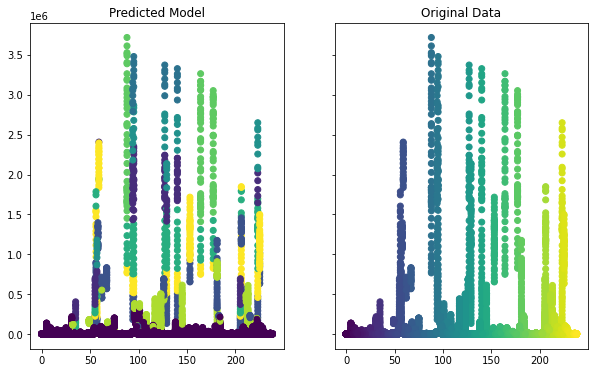

In [22]:
# Comparing the Orginal Data with Predicted Data
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
ax1.set_title('Predicted Data')
ax1.scatter(total_data.iloc[:, 0], total_data.iloc[:, 1],c=model.labels_)
ax2.set_title('Original Data')
ax2.scatter(total_data.iloc[:, 0], total_data.iloc[:, 1],c=total_data.iloc[:, 0])

Although the coloring between the two plots is different, We can see that predective model did a fairly good job of predicting the clusters within the dataset. We can also see that the model was not perfect - look at the data points along a cluster’s edge, We can see that it occasionally misclassified an observation from the dataset.

In [23]:
#Error Estimates
error_rates = []
error_rates.append(np.mean(y_kmeans != total_data.iloc[:, 0]))
print(error_rates)

[0.9941102229701304]
